# Randomly mutates amino acids based on their codon usage

In [1]:
import pandas as pd
import os
import numpy as np
import glob
from collections import defaultdict
import random
import pybedtools
from tqdm import trange, tqdm_notebook

seed = 3
random.seed(seed)

In [2]:
input_dir = '04_codon_mutation/inputs/'
output_dir = '04_codon_mutation/outputs/'

ensembl_cds_file = os.path.join(input_dir, 'human_ensembl110_cds.fa')
cdna_3utr_file = os.path.join(input_dir, 'human_ensembl_cdna_3UTR.txt')
cdna_5utr_file = os.path.join(input_dir, 'human_ensembl_cdna_5UTR.txt')
hotspots_with_coords_file = os.path.join(input_dir, 'deletion_effects_effects_human_water_30_nucleotides.coords.tsv')
output_all_uppercase_file = os.path.join(output_dir, f'human_30nt_mutated_hotspot_sequences_seed_{seed}.all_uppercase.fa')
output_file = os.path.join(output_dir, f'human_30nt_mutated_hotspot_sequences_seed_{seed}.fa')

# 1. Get peptide sequences from biomart
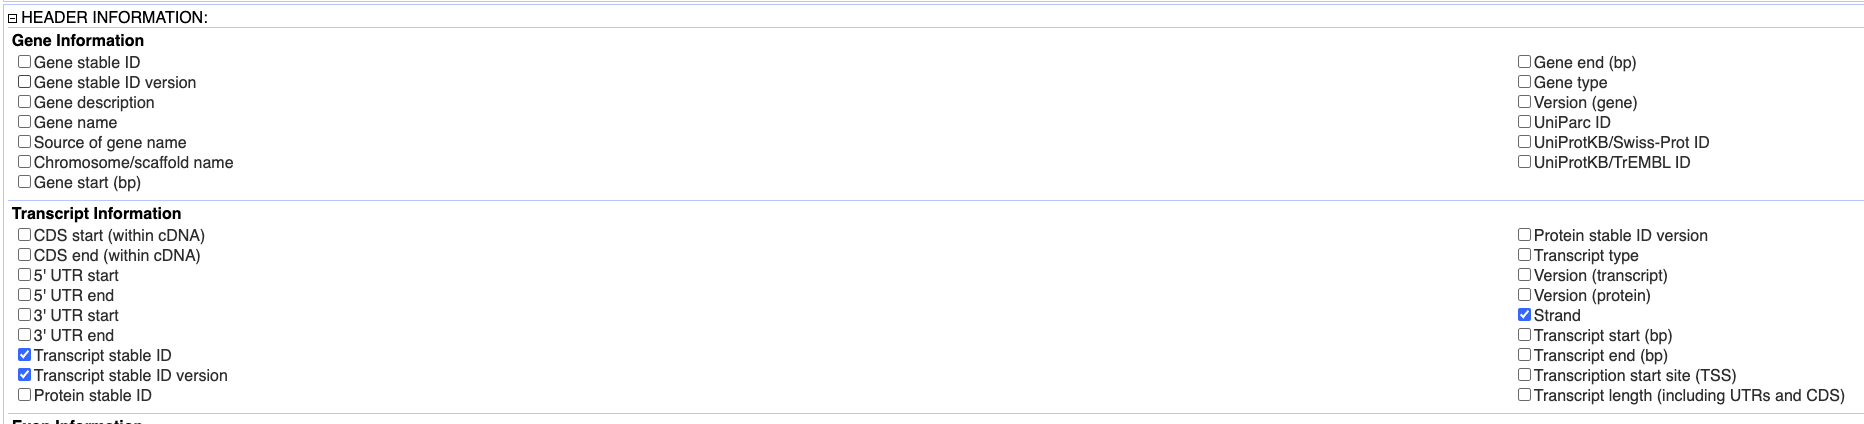

# Note: 3'UTR, 5'UTR and CDS sequences are already in proper orientation.
- "M" always at the first position of the peptide, stop codon always last

### Read in the CDS/UTR mRNA sequences
- discard any offsets (eg. "N" in the sequence)
- mouse statistics: Read in 62236 transcripts (from a total 66464, removing 4228 with offsets)
- human statistics: Read in 113494 transcripts (from a total 122614, removing 9120 with offsets)

In [3]:
cds_sequences = defaultdict(list)
two_offsets = 0
one_offset = 0

offsets = {}
# with open(os.path.join(input_dir, 'Ensembl_mouse_coding_strand.txt'), 'r') as f:
with open(ensembl_cds_file, 'r') as f:
    for line in f:
        if line.startswith('>'):
            # key = line[1:].rstrip().split('|')[2]  # mouse
            key = line[1:].rstrip().split('|')[0]
            offsets[key] = 0
        else:
            if not line.rstrip().startswith('Sequence unavailable'):
                if line.startswith('NNN'):
                    offsets[key] = 3
                if line.startswith('NN'):
                    offsets[key] = 2
                elif line.startswith('N'):
                    offsets[key] = 1
                cds_sequences[key].append(line.rstrip('\n'))
                
for key, seqs in cds_sequences.items():
    cds_sequences[key] = ''.join(seqs)

total_cds_sequences = len(cds_sequences.keys())

total_cds_with_offsets = 0
for key, offset in offsets.items():
    if offset > 0:
        total_cds_with_offsets += 1
        del cds_sequences[key]

cds_sequences = dict(cds_sequences)
print(f"Read in {len(cds_sequences.keys())} transcripts (from a total {total_cds_sequences}, removing {total_cds_with_offsets} with offsets)")

Read in 113494 transcripts (from a total 122614, removing 9120 with offsets)


In [19]:
cds_sequences['ENST00000587525']

'CAGGAGCAAGGGGACAAGATGATGGAGGAATACAGCCTGGAGAAAAATGAGAGGGCCTGCATTGATTTCGCCATCAGCGCCAAGCCGCTGACCCGACACATGCCGCAGAACAAGCAGAGCTTCCAGTACCGCATGTGGCAGTTCGTGGTGTCTCCGCCTTTCGAGTACACGATCATGGCCATGATCGCCCTCAACACCATCGTGCTTATGATGAAGTTCTATGGGGCTTCTGTTGCTTATGAAAATGCCCTGCGGGTGTTCAACATCGTCTTCACCTCCCTCTTCTCTCTGGAATGTGTGCTGAAAGTCATGGCTTTTGGGATTCTGAATTATTTCCGCGATGCCTGGAACATCTTCGACTTTGTGACTGTTCTGGGCAGCATCACCGATATCCTCGTGACTGAGTTTGGGAATAACTTCATCAACCTGAGCTTTCTCCGCCTCTTCCGAGCTGCCCGGCTCATCAAACTTCTCCGTCAGGGTTACACCATCCGCATTCTTCTCTGGACCTTTGTGCAGTCCTTCAAGGCCCTGCCTTATGTCTGTCTGCTGATCGCCATGCTCTTCTTCATCTATGCCATCATTGGGATGCAGGTGTTTGGTAACATTGGCATCGACGTGGAGGACGAGGACAGTGATGAAGATGAGTTCCAAATCACTGAGCACAATAACTTCCGGACCTTCTTCCAGGCCCTCATGCTTCTCTTCCGGAGTGCCACCGGGGAAGCTTGGCACAACATCATGCTTTCCTGCCTCAGCGGGAAACCGTGTGATAAGAACTCTGGCATCCTGACTCGAGAGTGTGGCAATGAATTTGCTTATTTTTACTTTGTTTCCTTCATCTTCCTCTGCTCGTTTCTGATGCTGAATCTCTTTGTCGCCGTCATCATGGACAACTTTGAGTACCTCACCCGAGACTCCTCCATCCTGGGCCCCCACCACCTGGATGAGTACGTGCGTGTCTGGGCCGAGTATGACCCCGCAGCTTGCGGTCGGATT

In [4]:
three_prime_utrs = defaultdict(list)
five_prime_utrs = defaultdict(list)

# with open(os.path.join(input_dir, 'mm39_3utrs.from_karen.fasta'), 'r') as f:  # Read in 149443 5'UTRs and 149443 3'UTRs
with open(cdna_3utr_file, 'r') as f:  # Read in 274578 5'UTRs and 274578 3'UTRs
    for line in f:
        if line.startswith('>'):
            key = line[1:].rstrip().split('|')[2]
        else:
            three_prime_utrs[key].append(line.rstrip())

for key, seqs in three_prime_utrs.items():
    three_prime_utrs[key] = ''.join(seqs)

# with open(os.path.join(input_dir, 'mm39_5utrs.from_karen.fasta'), 'r') as f:
with open(cdna_5utr_file, 'r') as f:
    for line in f:
        if line.startswith('>'):
            key = line[1:].rstrip().split('|')[2]
        else:
            five_prime_utrs[key].append(line.rstrip())

for key, seqs in five_prime_utrs.items():
    five_prime_utrs[key] = ''.join(seqs)

five_prime_utrs = dict(five_prime_utrs)
three_prime_utrs = dict(three_prime_utrs)

print(f"Read in {len(five_prime_utrs.keys())} 5'UTRs and {len(three_prime_utrs.keys())} 3'UTRs")

Read in 274578 5'UTRs and 274578 3'UTRs


### "Paste" 5'UTR - CDS - 3'UTR sequences together to get full mRNA transcript sequence
- Also obtain the following for each transcript:
    - length of each UTR and CDS
    - relative start coordinate of each UTR and CDS
    - relative stop coordinate of each UTR and CDS

In [5]:
def compile_mrna(transcript_id, five_prime_utrs, cds_sequences, three_prime_utrs):
    """
    'pastes' together UTR sequences with the mutated CDS sequence. 
    For now, we don't expect X in transcripts (I'm filtering them out above) but 
    in theory this function would replace X in sequences with stop signal (*)

    Also returns the starts of each 
    """
    has_5utr = False
    has_3utr = False
    transcript = ""
    five_prime_utr = ""
    three_prime_utr = ""
    
    if transcript_id in five_prime_utrs.keys() and five_prime_utrs[transcript_id] != "Sequence unavailable":
        five_prime_utr = five_prime_utrs[transcript_id]
    if transcript_id in three_prime_utrs.keys() and three_prime_utrs[transcript_id] != "Sequence unavailable":
        three_prime_utr = three_prime_utrs[transcript_id]

    try:
        coding_sequence = cds_sequences[transcript_id]
    except KeyError: # transcript has no coding sequence "sequence unavailable"
        return None, None, None, None
    # if coding_sequence.startswith('X'):
    #     try:
    #         assert five_prime_utr == ""
    #     except AssertionError:
    #         print(transcript_id, five_prime_utr)
    
    # if "X" in coding_sequence:
    #     coding_sequence = coding_sequence.replace("X", aa2codon("*"))  # stop codon readthrough
        
    transcript = five_prime_utr + coding_sequence + three_prime_utr
    lengths = {
        'utr5': len(five_prime_utr), 
        'cds': len(coding_sequence), 
        'utr3': len(three_prime_utr)
    }
    starts = {'utr5_start': 0, 'cds_start': len(five_prime_utr), 'utr3_start': len(five_prime_utr)+len(coding_sequence)}
    ends = {'utr5_end': len(five_prime_utr), 'cds_end': len(five_prime_utr)+len(coding_sequence), 'utr3_end': len(transcript)}
    try:
        assert "X" not in transcript  # ensure we've accounted for any offsets/weird frameshifts in coding sequence
    except AssertionError:
        # print(transcript_id)
        return None, None, None, None
    return transcript, lengths, starts, ends


### Check random transcripts to ensure the sequences match what we see on UCSC. Use small transcripts for convenience.

In [6]:
from random import choice
from string import ascii_uppercase

smallest_transcript = ''.join(choice(ascii_uppercase) for i in range(100000))

In [7]:
transcripts = {}
lengths = {}
starts = {}
ends = {}
for transcript in set(five_prime_utrs.keys()).union(cds_sequences.keys()).union(three_prime_utrs.keys()):
    try:
        tx, l, s, e = compile_mrna(transcript, five_prime_utrs, cds_sequences, three_prime_utrs)
        if tx is not None:  # has an "X" so we'll exclude
            transcripts[transcript] = tx
            lengths[transcript] = l
            starts[transcript] = s
            ends[transcript] = e
            if len(tx) < len(smallest_transcript):
                smallest_transcript = tx
                # print(f"QC: smallest transcript so far: {transcript} ({tx})")  # QC measure, check manually that the sequences are correct for some shorter sequences
    except TypeError:
        print(five_prime_utrs[transcript], transcript)
        raise

## Read in and filter hotspot coordinates

In [8]:
# input_file = os.path.join(input_dir, '40_nucleotide_deletion_differences_allseqs_names_low_threshold.coords.tsv')  # coords are 0 based
# input_file = os.path.join(input_dir, 'deletion_effects_threshold_1_30_nucleotides.coords.tsv')  # coords are 0 based
input_file = hotspots_with_coords_file  # coords are 0 based
impact = 'negative'  # positive, negative, both

df = pd.read_csv(input_file, sep='\t')
print(f"Before filtering impact score: {df.shape[0]}")

if impact == 'positive':
    df = df[df['difference'] >= 0.1]
elif impact == 'negative':
    df = df[df['difference'] <= -0.1]
elif impact == 'both':
    df = df[(df['difference'] >= 0.1) | (df['difference'] <= -0.1)]
print(f"After filtering impact score: {df.shape[0]}")

def get_chrom(row):
    try:
        return row['coords'].split(':')[0].replace('chrMT', 'chrM')
    except AttributeError:
        pass  # (eg. ENSMUST00000002344) doesn't exist in geneset anymore.

def get_strand(row):
    try:
        return row['coords'].split(':')[-1]
    except AttributeError:
        pass  # (eg. ENSMUST00000002344) doesn't exist in geneset anymore.

df['chrom'] = df.apply(get_chrom, axis=1)
df['strand'] = df.apply(get_strand, axis=1)
df['id'] = df['transcript_id']  # this is a useful column even if it's a little redundant.
df.set_index('transcript_id', inplace=True)
df.head()

Before filtering impact score: 6969886
After filtering impact score: 16462


,deletion_index_start,deletion_index_end,difference,synapse_probability,external_gene_name,coords,chrom,strand,id
transcript_id,,,,,,,,,
ENST00000000412,135,165,-0.189453,0.078125,M6PR-201,"chr12:8946398-8946405:-,chr12:8949487-8949510:-",chr12,-,ENST00000000412
ENST00000000412,150,180,-0.152344,0.115234,M6PR-201,"chr12:8946383-8946405:-,chr12:8949487-8949495:-",chr12,-,ENST00000000412
ENST00000000412,180,210,-0.230225,0.037354,M6PR-201,chr12:8946353-8946383:-,chr12,-,ENST00000000412
ENST00000000412,195,225,-0.214111,0.053467,M6PR-201,chr12:8946338-8946368:-,chr12,-,ENST00000000412
ENST00000000412,210,240,-0.145508,0.122070,M6PR-201,chr12:8946323-8946353:-,chr12,-,ENST00000000412


### Generate BedTools for each transcripts corresponding to hotspots
- need to use bedtools merge to merge overlapping hotspots (bookended hotspots are kept separate with -d -1)
- use the relative position (deletion_index start, end) instead of genomic position
- 0-based
- mouse statistics: Found 16 (out of 3577) transcripts with mismatched annotations between current version I'm using, and the annotations the model was trained on ({'ENSMUST00000038628', 'ENSMUST00000166580', 'ENSMUST00000170248', 'ENSMUST00000163716', 'ENSMUST00000044638', 'ENSMUST00000086674', 'ENSMUST00000170156', 'ENSMUST00000046223', 'ENSMUST00000167078', 'ENSMUST00000167946', 'ENSMUST00000086400', 'ENSMUST00000002344', 'ENSMUST00000004316', 'ENSMUST00000050686', 'ENSMUST00000093855', 'ENSMUST00000098566'})

In [9]:
hotspots_per_transcript = defaultdict(list)
wrong_annotations = set()  # annotations that were correct in whatever version the model was trained on, but not identical to annotations in this latest version (112 Ensembl)
score = '0'
progress = trange(len(set(df.index)), position=0, leave=False)
for transcript in set(df.index):
    transcript_regions = df.loc[[transcript]]
    intervals = []
    for index, row in transcript_regions.iterrows():  # handles each hotspot region within a transcript
        try:
            chrom = row['chrom']
            start = row['deletion_index_start']
            end = row['deletion_index_end']
            strand = row['strand']
            intervals.append(pybedtools.create_interval_from_list([chrom, start, end, transcript, score, strand]))
        except AttributeError:  # when relative coords exceed actual coords, it's represented as nan in the file (or when transcript doesn't exist in annotation)
            wrong_annotations.add(transcript)
        except TypeError:
            wrong_annotations.add(transcript)
    if len(intervals) > 0:  # if a transcript has at least one interval, merge overlapping intervals and MERGE bookended intervals as well.
        bedtool = pybedtools.BedTool(intervals).sort()
        bedtool = bedtool.merge(s=True, c='4,5,6', o='distinct,distinct,distinct', )
        hotspots_per_transcript[transcript] = bedtool
    progress.update(1)

print(f"Found {len(wrong_annotations)} (out of {len(set(df.index))}) transcripts with mismatched annotations between current version I'm using, and the annotations the model was trained on")
print(wrong_annotations)

100%|█████████▉| 3120/3121 [03:14<00:00, 15.93it/s]

Found 0 (out of 3121) transcripts with mismatched annotations between current version I'm using, and the annotations the model was trained on
set()


### Mutate hotspot regions inside CDS

In [10]:
codons = {
"TTT" : "F", "CTT" : "L", "ATT" : "I", "GTT" : "V",
"TTC" : "F", "CTC" : "L", "ATC" : "I", "GTC" : "V",
"TTA" : "L", "CTA" : "L", "ATA" : "I", "GTA" : "V", 
"TTG" : "L", "CTG" : "L", "ATG" : "M", "GTG" : "V", 
"TCT" : "S", "CCT" : "P", "ACT" : "T", "GCT" : "A",
"TCC" : "S", "CCC" : "P", "ACC" : "T", "GCC" : "A",
"TCA" : "S", "CCA" : "P", "ACA" : "T", "GCA" : "A",
"TCG" : "S", "CCG" : "P", "ACG" : "T", "GCG" : "A",
"TAT" : "Y", "CAT" : "H", "AAT" : "N", "GAT" : "D",
"TAC" : "Y", "CAC" : "H", "AAC" : "N", "GAC" : "D",
"TAA" : "U", "CAA" : "Q", "AAA" : "K", "GAA" : "E",
"TAG" : "U", "CAG" : "Q", "AAG" : "K", "GAG" : "E",
"TGT" : "C", "CGT" : "R", "AGT" : "S", "GGT" : "G",
"TGC" : "C", "CGC" : "R", "AGC" : "S", "GGC" : "G",
"TGA" : "U", "CGA" : "R", "AGA" : "R", "GGA" : "G",
"TGG" : "W", "CGG" : "R", "AGG" : "R", "GGG" : "G"
}

In [11]:
def aa2codon(aa, original_codon=None):
    """
    RANDOMLY returns a codon based on amino acid input.
    if original_codon is set, then this function will AVOID returning the original codon. 
    In other words, the codon returned will never match the original_codon.
    """
    D = {
      "F": ["TTT", "TTC"],
      "L": ["TTA", "TTG", "CTT", "CTC", "CTA", "CTG"],
      "I": ["ATT", "ATC", "ATA"],
      "M": ["ATG"],  # Start codon
      "V": ["GTT", "GTC", "GTA", "GTG"],
      "Y": ["TAT", "TAC"],
      "H": ["CAT", "CAC"],
      "Q": ["CAA", "CAG"],
      "T": ["ACT", "ACC", "ACA", "ACG"],
      "A": ["GCT", "GCC", "GCA", "GCG"],
      "S": ["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
      "R": ["AGA", "AGG", "CGT", "CGC", "CGA", "CGG"],
      "G": ["GGT", "GGC", "GGA", "GGG"],
      "P": ["CCT", "CCC", "CCA", "CCG"],
      "C": ["TGC", "TGT"],
      "W": ["TGG"],
      "D": ["GAT", "GAC"],
      "E": ["GAA", "GAG"],
      "K": ["AAA", "AAG"],
      "N": ["AAT", "AAC"],
      "X": ["X"],
      "U": ["TAA", "TAG", "TGA"],
    # "*": ["TAA", "TAG", "TGA"],  # Stop codons
    }
    codons = D[aa]
    if len(codons) == 1:  # we only have one codon to return, so return it. Do not shuffle.
        return codons[0]
    else:
        codons.remove(original_codon)
        return codons[random.randint(0,len(codons)-1)]
    raise

### Actual mutation code below
- mutated_sequence = string representing the final mutated sequence.
- iterates over the entire transcript with a global counter (gc)
- once gc position matches cds start site position (cc), start counting by 3's (i)
- check each codon to see if it's located within a hotspot
- if inside a hotspot, mutate the codon. Else, just add the same sequence back
- once outside the cds ( >= cds_end), continue adding the rest of the transcript

In [12]:
def mutate_cds(transcript, hotspot_bedtool, starts=starts, ends=ends, lengths=lengths, transcripts=transcripts, codons=codons):
    transcript_sequence = transcripts[transcript]
    mutated_sequence = []
    cds_start = starts[transcript]['cds_start']
    cds_end = ends[transcript]['cds_end']
    gc = 0  # global counter, iterates across mRNA transcript
    while gc <= len(transcript_sequence)-1: # -1 for 0-based
        if gc >= cds_start and gc < cds_end:
            cc = gc  # cds counter
            for i in range(cc, cc+lengths[transcript]['cds'], 3):
                codon = transcript_sequence[i:i+3]
                mutated=False
                for interval in hotspot_bedtool:
                    hotspot_start = interval.start
                    hotspot_end = interval.end
                    # print('checking hotspots', hotspot_start, hotspot_end)
                    if i+2 >= hotspot_start and i < hotspot_end: # check if inside hotspot (or within one codon of a hotspot)
                        aa = codons[codon]
                        # print(hotspot_start, hotspot_end, aa, end=',')
                        mutated_sequence.append(aa2codon(aa, codon).lower())
                        mutated=True
                if mutated == False:
                    mutated_sequence.append(codon)
                gc+=3
        else:
            mutated_sequence.append(transcript_sequence[gc])
            gc+=1    
    return ''.join(mutated_sequence)

# mutate_cds('ENSMUST00000150664', hotspots_per_transcript['ENSMUST00000150664']).upper()  # test/QC

### Write to file

### filter edge-case transcripts and write to file
- When compared to its peptide sequence, some transcripts do not translate perfectly (see example image "X" marking off-frame CDS stop).
- **Remove these 30 from the LLM input**
- In total, we should have 3561 - 30 = 3531 transcripts
- 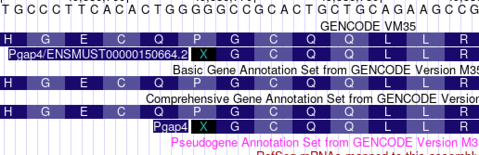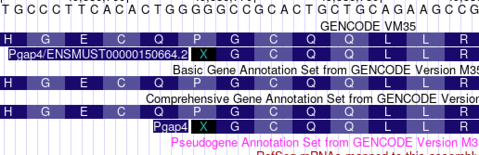
- mismatched_sequences: 30 {'ENSMUST00000239083', 'ENSMUST00000112268', 'ENSMUST00000082432', 'ENSMUST00000023057', 'ENSMUST00000238832', 'ENSMUST00000071648', 'ENSMUST00000228495', 'ENSMUST00000139476', 'ENSMUST00000082421', 'ENSMUST00000101801', 'ENSMUST00000060435', 'ENSMUST00000082430', 'ENSMUST00000096109', 'ENSMUST00000082409', 'ENSMUST00000082392', 'ENSMUST00000150664', 'ENSMUST00000182222', 'ENSMUST00000228119', 'ENSMUST00000176363', 'ENSMUST00000159216', 'ENSMUST00000143143', 'ENSMUST00000094469', 'ENSMUST00000082418', 'ENSMUST00000082396', 'ENSMUST00000082402', 'ENSMUST00000107924', 'ENSMUST00000082424', 'ENSMUST00000219624', 'ENSMUST00000082408', 'ENSMUST00000082405'}
- **For Human** We checked a few IDs from human_30nt_mismatch_ids.csv and confirmed mismatches are due to the same reason as above.

In [18]:
mismatched_sequences = set(pd.read_csv(os.path.join(input_dir, 'human_30nt_mismatch_ids.csv'), index_col=0).index)
# mismatched_sequences = set()
print(len(mismatched_sequences), mismatched_sequences)

121 {'ENST00000450338', 'ENST00000491829', 'ENST00000533813', 'ENST00000698128', 'ENST00000286196', 'ENST00000489498', 'ENST00000604624', 'ENST00000382762', 'ENST00000644624', 'ENST00000695885', 'ENST00000422808', 'ENST00000373471', 'ENST00000279463', 'ENST00000441517', 'ENST00000028008', 'ENST00000533616', 'ENST00000424598', 'ENST00000514032', 'ENST00000518174', 'ENST00000672146', 'ENST00000472823', 'ENST00000529403', 'ENST00000397267', 'ENST00000522990', 'ENST00000520911', 'ENST00000453040', 'ENST00000681941', 'ENST00000612954', 'ENST00000560107', 'ENST00000551994', 'ENST00000425642', 'ENST00000706492', 'ENST00000690799', 'ENST00000548838', 'ENST00000622947', 'ENST00000520303', 'ENST00000671775', 'ENST00000435891', 'ENST00000684231', 'ENST00000519928', 'ENST00000489591', 'ENST00000594528', 'ENST00000554611', 'ENST00000691612', 'ENST00000187830', 'ENST00000696602', 'ENST00000497866', 'ENST00000693743', 'ENST00000261197', 'ENST00000571460', 'ENST00000412285', 'ENST00000446927', 'ENST00

In [14]:
mutated_sequences = {}
wrong_transcripts = []
progress = trange(len(hotspots_per_transcript.keys()), position=0, leave=False)
with open(output_file, 'w') as o:
    for transcript, bedtool in hotspots_per_transcript.items():
        if transcript in cds_sequences.keys() and transcript not in mismatched_sequences:
            try:
                mutated_sequences[transcript] = mutate_cds(transcript, bedtool)
                o.write(f'>{transcript}\n{mutated_sequences[transcript]}\n')
            except KeyError as e:
                wrong_transcripts.append(transcript)
        progress.update(1)

print(len(wrong_transcripts))

100%|█████████▉| 3120/3121 [00:37<00:00, 79.86it/s] 

0


### For QC purposes, extract just the CDS so Karen can double check the mutations

In [15]:
with open(os.path.join(output_dir, f'human_30nt_mutated_hotspot_sequences_seed_{seed}.CDS_only.fa'), 'w') as o:
    for transcript, sequence in mutated_sequences.items():
        mutated_cds_only_sequence = sequence[starts[transcript]['cds_start']:ends[transcript]['cds_end']]
        o.write(f">{transcript}\n{mutated_cds_only_sequence}\n")

In [16]:
mutated_cds = defaultdict(list)
with open(os.path.join(output_dir, f'human_30nt_mutated_hotspot_sequences_seed_{seed}.CDS_only.fa'), 'r') as f:
    for line in f:
        if line.startswith('>'):
            key = line[1:].rstrip()
        else:
            mutated_cds[key].append(line.rstrip())

for key, seqs in mutated_cds.items():
    mutated_cds[key] = ''.join(seqs)


### Write final file as all uppercase for LLM input

In [17]:
with open(output_all_uppercase_file, 'w') as o:
    with open(output_file, 'r') as f:
        for line in f:
            o.write(line.upper())

### Scratch/QC. Check UCSC for reasons why peptides aren't matching codon translations.